# A training example in Pytorch

Enchanced upon https://github.com/cmudeeplearning11785/Fall2018-tutorials/blob/master/recitation-2/pytorch_example.ipynb

## Task
In this notebook we will train a neural network to do a simple task. This will be a classification task : as explained in the first week of lectures, classification basically means to find a *decision boundary* over a space of real numbers. For representation purposes we will work with a 2D example : the decision boundary will be a cercle. More precisely, it will be the unit circle in the plan.
![](unitycircle.png)
## Sampling
We will generate points $(x_1,x_2)$ to classify, and their class $y$. The actual decision fonction is $y=1_{x_1^2+x_2^2<1}$.

To have a balanced dataset with about as many points in each class, we will sample uniformly over polar coordinates,  within the circle of center 0 and radius 2.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
def sample_points(n):
    """
    Generates datapoints randomly
    n - a number of datapoints to generate
    returns (X,Y), where X of shape (n,2) is the numpy array of points and Y is the (n) array of classes   
    """
    radius = np.random.uniform(low=0,high=2,size=n).reshape(-1,1) # uniform radius between 0 and 2
    angle = np.random.uniform(low=0,high=2*np.pi,size=n).reshape(-1,1) # uniform angle
    x1 = radius*np.cos(angle)
    x2=radius*np.sin(angle)
    y = (radius<1).astype(int).reshape(-1)
    x = np.concatenate([x1,x2],axis=1)
    return x,y

In [3]:
def mk_dataset(n_samples=10000, test_factor=5, val_factor=5):
    """
    Generates the data
    Takes:
    n_samples - number of sample for train dataset
    test_factor, train_factor - defines the size of test adn val samples 
    as a fraction (1/x) of train sample.
    
    returns the dataset containing train, val, test as a tuple
    """
    trainx,trainy = sample_points(n_samples)
    valx,valy = sample_points(n_samples//test_factor)
    testx,testy = sample_points(n_samples//val_factor)
    #print(trainx.shape,trainy.shape)
    
    #To train our model, we will need to feed it with tensors. 
    #Let's transform our generated numpy arrays :
    trainx = torch.from_numpy(trainx).float()
    valx = torch.from_numpy(valx).float()
    testx = torch.from_numpy(testx).float()
    trainy = torch.from_numpy(trainy)
    valy = torch.from_numpy(valy)
    testy = torch.from_numpy(testy)
    #print(trainx.type(),trainy.type())
    
    return (trainx,trainy,valx,valy, testx, testy)

In [4]:
# Approximate train times per model:
#n_samples=500000  ~5 minutes on GPU
#n_samples=10000   ~5 seconds on GPU

## Model

Our model will be a multi-layer perceptron with one hidden layer, and an output of size 2 since we have two classes. Since it is a binary classification task we could also use just one output and a zero threshold, but we will use two to illustrate the use of the pytorch Cross-Entropy loss (with one output, you would use BinaryCrossEntropy).

As you know from the lectures, such a model cannot represent a circular boundary but could represent a polygonal boundary, whose number of sides is the number of neurons on the hidden layer. For example, with 6 hidden neurons the model could compute a hexagonal boundary that approximate the unity circle, such as :
![](hexagon.png)

Of course the trained model won't compute an actual hexagone, due to the activation that isn't a threshold, and the liberty of the final layer's weights (it does not have to be an AND). We can actually expect *better* accuracy than what a hexagon could do.

In [5]:
def generate_single_hidden_MLP(n_hidden_neurons, 
                               active=nn.ReLU, active_args=(), 
                               init=None, init_args=()):
    """
    Generates a model with one input, one hidden and one output layer
    for binary classification( input and output layers have two neurons)
    Arguments:
    n_hidden_neurons - a number of neurons in the hidden layer 
    active - activation function (default=nn.ReLU)
    active_args - extra parameters of the activation function (default - empty), specified as a dict of named parameters
    init - weights initialization function (default=None)
    init_args - extra parameters of initialization functions (defauilt=()), specified as a typle of non-named parameters.
    
    returns generated network object
    """

    net = nn.Sequential(
        nn.Linear(2,n_hidden_neurons),
        active(*active_args),
        nn.Linear(n_hidden_neurons,2)
    )
    if init is not None:
        for m in net.children():
            if type(m) == nn.Linear:
                init(m.weight, *init_args)
    
    return net

#unit test
m0 = generate_single_hidden_MLP(6, nn.Threshold, (0.5, 0), )
print(m0)
for m in m0.children():
    if type(m) == nn.Linear:
        print(m.weight, m.bias)
        

Sequential(
  (0): Linear(in_features=2, out_features=6, bias=True)
  (1): Threshold(threshold=0.5, value=0)
  (2): Linear(in_features=6, out_features=2, bias=True)
)
Parameter containing:
tensor([[ 0.1477, -0.6581],
        [ 0.5295,  0.5635],
        [ 0.3561, -0.0985],
        [ 0.0948,  0.4280],
        [-0.5747,  0.2995],
        [ 0.1525,  0.5269]], requires_grad=True) Parameter containing:
tensor([-0.4158, -0.4359, -0.2005,  0.6908, -0.5287, -0.3529], requires_grad=True)
Parameter containing:
tensor([[-0.2683,  0.3530, -0.1168,  0.0370, -0.2612, -0.1415],
        [ 0.4042,  0.0803, -0.0109, -0.0271, -0.4008,  0.0502]],
       requires_grad=True) Parameter containing:
tensor([-0.0025, -0.2826], requires_grad=True)


## Activation functions

Let's compare effect of different activation function

### Step activation

It's not defined in the framework, but we define it

In [6]:
class step_activation(nn.Module):
    """
    Implementation of step function (absent from Pytorch)
    """

    def __init__(self):
        super(step_activation, self).__init__()
        
    def forward(self, x):
        sign = torch.sign(x)
        return torch.clamp(sign, 0, 1)

#unit test
step_activation()(torch.Tensor([-2.0, -1.0, -0.0, 0.0, 1.0, 2.0])).numpy()

array([0., 0., 0., 0., 1., 1.], dtype=float32)

### Sigmoid, ReLU

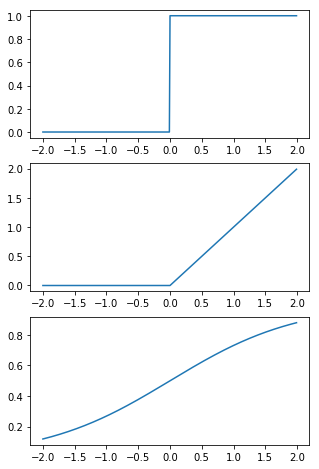

In [7]:
import numpy as np
t = np.arange(-2.0, 2.0, 0.01)
tt= torch.Tensor(t)

fig, axes = plt.subplots(3, figsize=(5,8))

activations = [step_activation, nn.ReLU, nn.Sigmoid]

for ax, active in zip(axes, activations):
    ax.plot(t, active()(tt).numpy())

plt.show()

## Initial distributions

https://pytorch.org/docs/stable/nn.html#torch-nn-init

```
torch.nn.init.uniform_(tensor, a=0, b=1)
torch.nn.init.normal_(tensor, mean=0, std=1)
nn.init.xavier_uniform_(tensor, gain=1)
nn.init.constant_(tensor, val)
nn.init.xavier_normal_(tensor, gain=1)
nn.init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
nn.init.orthogonal_(tensor, gain=1)
...

```

## Training and diplaying routines
Now we will define our training routine. There is the question of whether to perform our traing on CPU or GPU. The best thing to do is to use a flag variable that you will set, when you actually do the training.

In [8]:
def training_routine_iterate(net, dataset, n_iters, gpu, 
                             optimizer,
                             criterion,
                             verbose=True):
    """
    Training routine that implements forward and backward passes,
    optionally prints intermediate stats,
    returns tained model
    """
    
    train_data,train_labels,val_data,val_labels, _, _ = dataset
    
    for i in range(n_iters):
        # forward pass
        train_output = net(train_data)
        train_loss = criterion(train_output,train_labels)
        # backward pass and optimization
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        # In verbose mode, print stats every so often,
        # in non-verbose mode - print only the final value
        n_info_iter = 10000
        
        if (i == n_iters - 1) or (verbose and (i % n_info_iter == 0)):
            print("At iteration", i+1)
            
            # compute the accuracy of the prediction
            train_accuracy = (train_labels.eq(train_output.argmax(dim=1))).float().mean()

            # Now for the validation set
            val_output = net(val_data)
            val_loss = criterion(val_output,val_labels)

            # compute the accuracy of the prediction
            val_accuracy = (val_labels.eq(val_output.argmax(dim=1))).float().mean()

            metrics = [train_loss, train_accuracy, val_loss, val_accuracy]
            info_vals= [float(v.cpu().detach().numpy()) for v in metrics]
            print("train loss {0:0.2f} train acc {1:0.2f} val loss {2:0.2f} val acc {3:0.2f}".format(*info_vals))

    #net = net.cpu()
    return net

In [9]:
def make_title(active, active_args, opti, opti_p, init, init_p, cycle, n_epochs):
    """
    F helper function to make up a title for sample plots
    """
    active_title = active.__name__+str(active_args)
    opti_title = opti.__name__+"("+\
         ",".join("{}={}".format(k, v) for k, v in opti_p.items())+")"
    opti_title += '\n'
    #init_title = "" if init is None else init.__name__+"("+\
    #     ",".join("{}={}".format(k, v) for k, v in init_p.items())+")"
    init_title = "" if init is None else init.__name__+ str(init_p)
    iter_title = "iter={}".format((cycle+1)*n_epochs)
    title = " ". join([active_title, opti_title, init_title, iter_title])
    return title

In [10]:
import timeit, copy
from itertools import product

def compute_models(activations, n_hidden_neurons, dataset,
                   optimizers, opti_params,
                   initializations=[(None, None)],
                   n_epochs=10000, gpu=True, verbose=False):
    """
    Trains models with specified parameters:
    activations - a list of (activation function, parameters) tuples to use in models
    n_hidden_neurons - a numberof hidden nuerons
    dataset - a tuple of train, test, val samples,
    optimizers - a list of optimizitoin functions to use with models
    opti_params - a list of optimization function params to use with optimization functions. 
      Typically, this is used to vary parameter of one optimization function.
    initializations - a list of (weight init functins, parameters) tuples (default=[(None, None)])
    n_epochs - a number of training epochs (default=10000). 
      It can be specified as integer (actually perform so may iteractions)
      or can be specified as (n_iter_per_cycle, n_cycles) tuple, which means checkpoint (infer) the model
      n_cycles times, after n_iter_per_cycle iterations
    gpu - boolean flag of whether to use GPU or not (default=True)
    verbose - print progress stats (loss and accuracy) every so often (default=False). 
      When False, only the final stats are printed.
    
    returns a list of models along with plot titles and test dataset inferred values.
    """
   
    if gpu:
        data = tuple(x.cuda() for x in dataset)
    else:
        data = dataset

    models = []
    everything = product(activations, optimizers, opti_params, initializations, n_hidden_neurons)
    #print(list(everything))
    for (active, active_args), opti, opti_p, (init, init_p), n in everything:
        #print((active, active_args), opti, opti_p, (init, init_p), n)
        model = generate_single_hidden_MLP(n, active, active_args, init=init, init_args=init_p)
        if gpu: model = model.cuda()
        criterion = nn.CrossEntropyLoss()
        optimizer = opti(model.parameters(),**opti_p)
        
        # n_epochs can be given as:
        # i: number of iterations ones
        # (i, cycle):  cycle times i iterations
        # after each time, save model weights 
        if (isinstance(n_epochs, int)):
            train_cycles = 1
        else:
            n_epochs, train_cycles = n_epochs
        
        for cycle in range(train_cycles):
            title = make_title(active, active_args, opti, opti_p, init, init_p, cycle, n_epochs)

            print("Computing {} for {} neurons ...".format(title, n), end='')
            start = timeit.default_timer()
            m1 = training_routine_iterate(model, data, n_epochs, gpu, 
                             optimizer, criterion,
                             verbose=verbose)
            stop = timeit.default_timer()
            print("\b\b\b in {:.2f} sec".format(stop-start))
            models.append(
                {"model" : m1,
                 "weights": copy.deepcopy(m1.state_dict()),
                 "out": m1(data[-2]).argmax(dim=1).cpu().detach().numpy(), # inference on test
                 #"weights_m":model.state_dict(),
                 #"weights":m1.state_dict(),
                 "title" : title,
                 "neurons": n}
            )
    return models

In [11]:
import math
def get_grid(n):
    """
    Helper to arrange plots on a grid in a nice way.
    
    Takes number of plots, returns a tuple of (horizontal, vertical) sizes.
    """
    if n in [1,4,9]:
        w=int(math.sqrt(n))
        d=w
    elif n<4:        w,d=n,1
    elif n<7:        w,d=3,2
    else    :        w=4; d=n//w + (1 if n%w!=0 else 0)
    return d,w
#unit test
get_grid(5)

(2, 3)

In [12]:
from itertools import chain

def print_models(models, datapoints, grid=None, fig_size_factor=5):
    """
    Draws given models' samples
    
    Takes: models list, test dataset, optionally grid size and a factor to scale the plots.
    """
    if grid is None:
        grid = get_grid(len(models))

    fig, axes = plt.subplots( 
        *grid , squeeze=False,
        sharex='col', sharey='row', 
        figsize=(fig_size_factor*grid[1],fig_size_factor*grid[0])
    )
    
    for model, ax in zip(models, chain.from_iterable(axes)):
        out = model['out'] 
        green = datapoints.numpy()[np.where(out==1)]
        red = datapoints.numpy()[np.where(out==0)]

        ax.add_artist(plt.Circle((0, 0), 1, alpha=0.5, color='y'))
        ax.add_artist(plt.Circle((0, 0), 1, color='b',fill=False))

        ax.scatter(x=green[:,0],y=green[:,1], color='g',)
        ax.scatter(x=red[:,0],y=red[:,1], color='r',)

        ax.set_title(model['title'])
        ax.set_ylabel(str(model['neurons']) + " neurons")

## Use of GPU flag

In [13]:
torch.cuda.is_available() # to know if you actually can use the GPU

True

In [14]:
gpu = True #default, but flips if cuda is not available
gpu = gpu or torch.cuda.is_available() 
gpu

True

## Different activations 

In [15]:
n_samples = 10000
dataset = mk_dataset(n_samples, test_factor=5, val_factor=1)
testx = dataset[-2]

Computing step_activation() SGD(lr=0.01)
  iter=5000 for 2 neurons ...At iteration 5000
train loss 0.62 train acc 0.65 val loss 0.61 val acc 0.64
 in 2.15 sec
Computing step_activation() SGD(lr=0.01)
  iter=5000 for 3 neurons ...At iteration 5000
train loss 0.53 train acc 0.77 val loss 0.54 val acc 0.76
 in 2.47 sec
Computing step_activation() SGD(lr=0.01)
  iter=5000 for 6 neurons ...At iteration 5000
train loss 0.48 train acc 0.78 val loss 0.47 val acc 0.79
 in 2.65 sec
Computing Sigmoid() SGD(lr=0.01)
  iter=5000 for 2 neurons ...At iteration 5000
train loss 0.69 train acc 0.60 val loss 0.69 val acc 0.58
 in 2.16 sec
Computing Sigmoid() SGD(lr=0.01)
  iter=5000 for 3 neurons ...At iteration 5000
train loss 0.69 train acc 0.65 val loss 0.69 val acc 0.61
 in 2.15 sec
Computing Sigmoid() SGD(lr=0.01)
  iter=5000 for 6 neurons ...At iteration 5000
train loss 0.69 train acc 0.65 val loss 0.69 val acc 0.63
 in 2.17 sec
Computing ReLU() SGD(lr=0.01)
  iter=5000 for 2 neurons ...At it

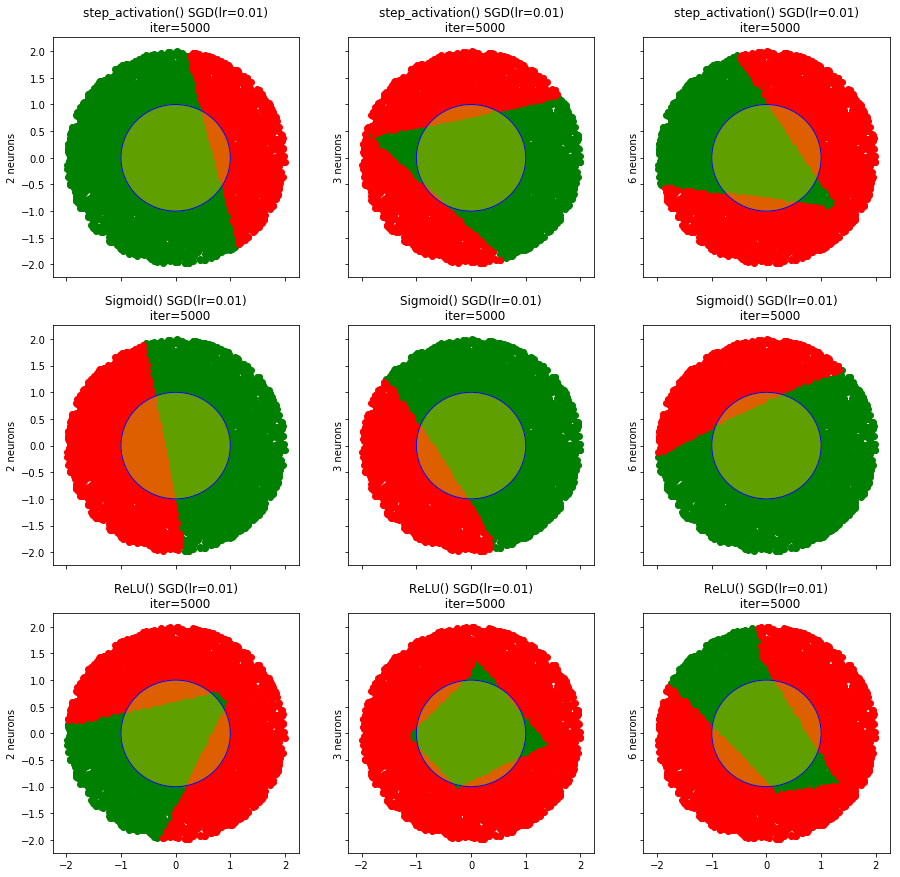

In [16]:
activations = [(step_activation, ()),(nn.Sigmoid, ()), (nn.ReLU, ())]
n_hidden_neurons = [2, 3, 6]
optimizers = [torch.optim.SGD]
opti_params = [{'lr': 0.01}]
n_epochs = 5000
models = compute_models(activations, n_hidden_neurons, dataset,
                        optimizers=optimizers, opti_params=opti_params,
                        n_epochs=n_epochs, gpu=gpu)
print_models(models, testx)

## Different activations  100k Samples

In [17]:
n_samples = 100000
dataset = mk_dataset(n_samples)
testx= dataset[-2]

Computing step_activation() SGD(lr=0.01)
  iter=5000 for 2 neurons ...At iteration 5000
train loss 0.58 train acc 0.70 val loss 0.58 val acc 0.70
 in 17.34 sec
Computing step_activation() SGD(lr=0.01)
  iter=5000 for 3 neurons ...At iteration 5000
train loss 0.55 train acc 0.73 val loss 0.55 val acc 0.72
 in 17.48 sec
Computing step_activation() SGD(lr=0.01)
  iter=5000 for 6 neurons ...At iteration 5000
train loss 0.54 train acc 0.74 val loss 0.54 val acc 0.74
 in 17.98 sec
Computing Sigmoid() SGD(lr=0.01)
  iter=5000 for 2 neurons ...At iteration 5000
train loss 0.69 train acc 0.59 val loss 0.69 val acc 0.59
 in 17.34 sec
Computing Sigmoid() SGD(lr=0.01)
  iter=5000 for 3 neurons ...At iteration 5000
train loss 0.69 train acc 0.62 val loss 0.69 val acc 0.62
 in 17.39 sec
Computing Sigmoid() SGD(lr=0.01)
  iter=5000 for 6 neurons ...At iteration 5000
train loss 0.69 train acc 0.57 val loss 0.69 val acc 0.57
 in 17.76 sec
Computing ReLU() SGD(lr=0.01)
  iter=5000 for 2 neurons ..

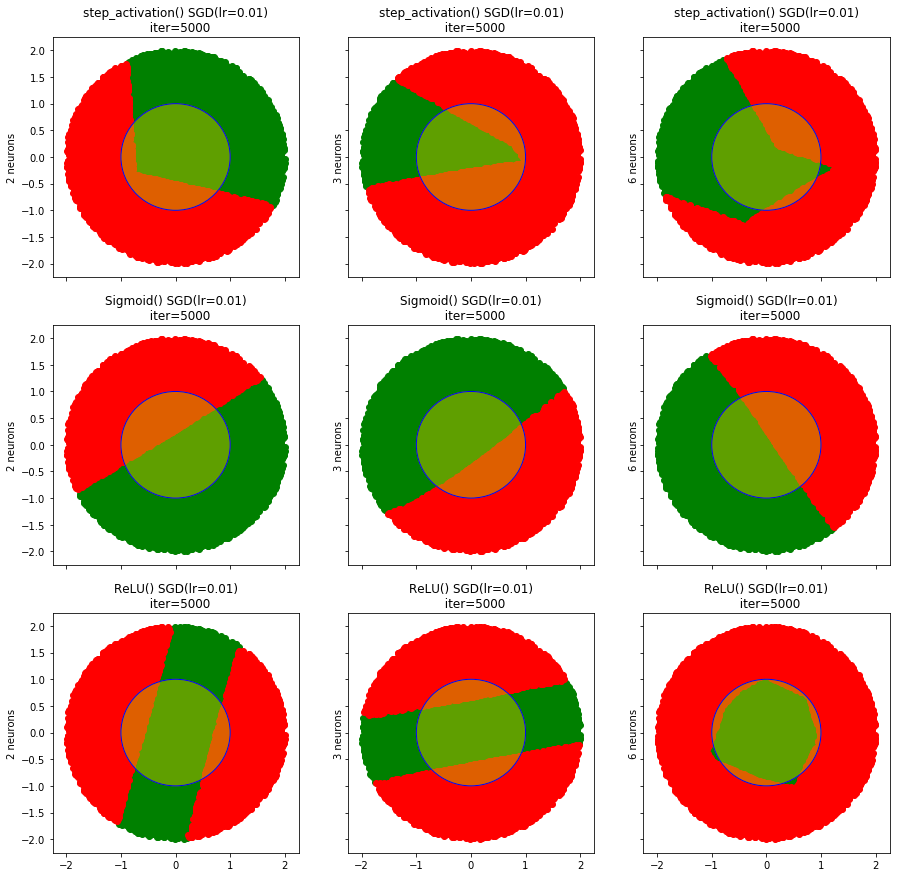

In [18]:
activations = [(step_activation, ()),(nn.Sigmoid, ()), (nn.ReLU, ())]
n_hidden_neurons = [2, 3, 6]
n_epochs = 5000

models = compute_models(activations, n_hidden_neurons, dataset,
                       optimizers=optimizers, opti_params=opti_params,
                       n_epochs=n_epochs, gpu=gpu)
print_models(models, testx)

## Let's take closer look at models with Step Activation

In [19]:
n_samples = 10000
dataset = mk_dataset(n_samples, test_factor=5, val_factor=1)
testx = dataset[-2]

### Different number of Neurons

Computing step_activation() SGD(lr=0.01)
  iter=1000 for 1 neurons ...At iteration 1000
train loss 0.69 train acc 0.54 val loss 0.69 val acc 0.54
 in 0.39 sec
Computing step_activation() SGD(lr=0.01)
  iter=1000 for 2 neurons ...At iteration 1000
train loss 0.68 train acc 0.58 val loss 0.68 val acc 0.57
 in 0.43 sec
Computing step_activation() SGD(lr=0.01)
  iter=1000 for 3 neurons ...At iteration 1000
train loss 0.64 train acc 0.77 val loss 0.64 val acc 0.76
 in 0.43 sec
Computing step_activation() SGD(lr=0.01)
  iter=1000 for 4 neurons ...At iteration 1000
train loss 0.63 train acc 0.60 val loss 0.63 val acc 0.60
 in 0.43 sec
Computing step_activation() SGD(lr=0.01)
  iter=1000 for 6 neurons ...At iteration 1000
train loss 0.54 train acc 0.81 val loss 0.55 val acc 0.81
 in 0.43 sec
Computing step_activation() SGD(lr=0.01)
  iter=1000 for 8 neurons ...At iteration 1000
train loss 0.50 train acc 0.84 val loss 0.50 val acc 0.83
 in 0.43 sec


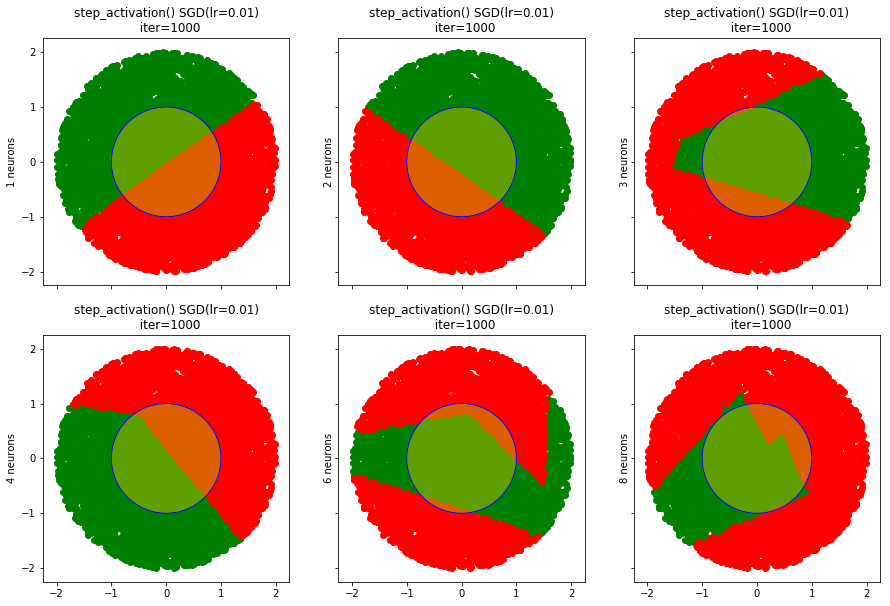

In [20]:
activations = [(step_activation, ())]
optimizers = [torch.optim.SGD]
opti_params = [{'lr': 0.01}]
n_hidden_neurons = [1, 2, 3, 4, 6, 8]
n_epochs = 1000

models=compute_models(activations, n_hidden_neurons, dataset, 
                      optimizers=optimizers, opti_params=opti_params,
                      n_epochs=n_epochs, gpu=gpu)

print_models(models, testx)

### Different number of epochs

Computing step_activation() SGD(lr=0.01)
  iter=100 for 6 neurons ...At iteration 1
train loss 0.70 train acc 0.44 val loss 0.71 val acc 0.44
At iteration 100
train loss 0.67 train acc 0.70 val loss 0.67 val acc 0.70
 in 0.05 sec
Computing step_activation() SGD(lr=0.01)
  iter=200 for 6 neurons ...At iteration 1
train loss 0.67 train acc 0.70 val loss 0.67 val acc 0.70
At iteration 100
train loss 0.65 train acc 0.73 val loss 0.65 val acc 0.73
 in 0.04 sec
Computing step_activation() SGD(lr=0.01)
  iter=300 for 6 neurons ...At iteration 1
train loss 0.65 train acc 0.73 val loss 0.65 val acc 0.73
At iteration 100
train loss 0.62 train acc 0.73 val loss 0.62 val acc 0.73
 in 0.04 sec
Computing step_activation() SGD(lr=0.01)
  iter=400 for 6 neurons ...At iteration 1
train loss 0.62 train acc 0.73 val loss 0.62 val acc 0.73
At iteration 100
train loss 0.60 train acc 0.73 val loss 0.60 val acc 0.73
 in 0.04 sec
Computing step_activation() SGD(lr=0.01)
  iter=500 for 6 neurons ...At iter

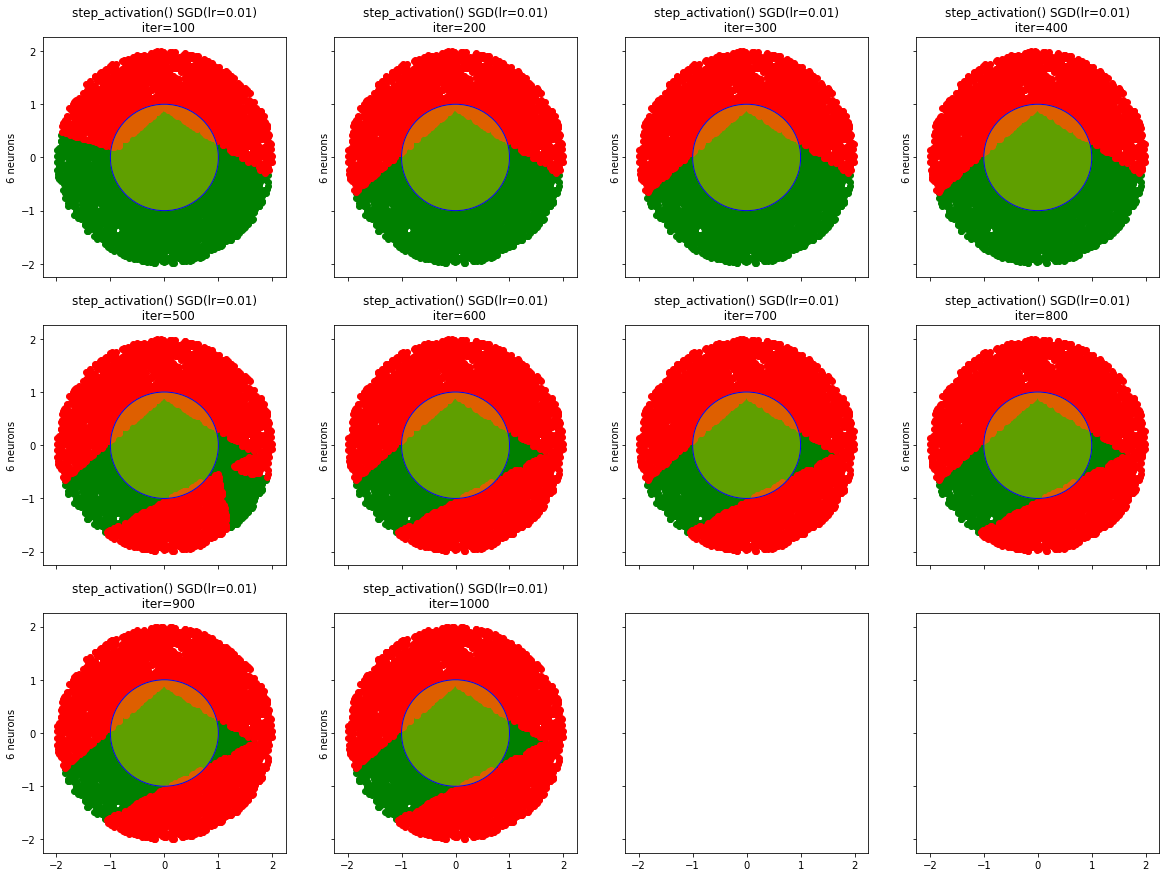

In [21]:
#activations = [(nn.ReLU,())]
activations = [(step_activation, ())]
optimizers = [torch.optim.SGD]
opti_params = [{'lr': 0.01}]
n_hidden_neurons = [6]
n_epochs = (100, 10) # this mean checkpoint (infer) 10 times,  each after 100 epochs

models=compute_models(activations, n_hidden_neurons, dataset, 
                      optimizers=optimizers, opti_params=opti_params,
                      n_epochs=n_epochs, gpu=gpu, verbose=True)

print_models(models, testx)

### Effect of Learning rate

Computing step_activation() SGD(lr=10)
  iter=1000 for 6 neurons ...At iteration 1000
train loss 1.23 train acc 0.80 val loss 0.84 val acc 0.81
 in 0.43 sec
Computing step_activation() SGD(lr=1)
  iter=1000 for 6 neurons ...At iteration 1000
train loss 0.44 train acc 0.78 val loss 0.45 val acc 0.78
 in 0.43 sec
Computing step_activation() SGD(lr=0.1)
  iter=1000 for 6 neurons ...At iteration 1000
train loss 0.51 train acc 0.74 val loss 0.52 val acc 0.72
 in 0.43 sec
Computing step_activation() SGD(lr=0.01)
  iter=1000 for 6 neurons ...At iteration 1000
train loss 0.55 train acc 0.82 val loss 0.55 val acc 0.81
 in 0.43 sec
Computing step_activation() SGD(lr=0.001)
  iter=1000 for 6 neurons ...At iteration 1000
train loss 0.69 train acc 0.48 val loss 0.69 val acc 0.48
 in 0.43 sec


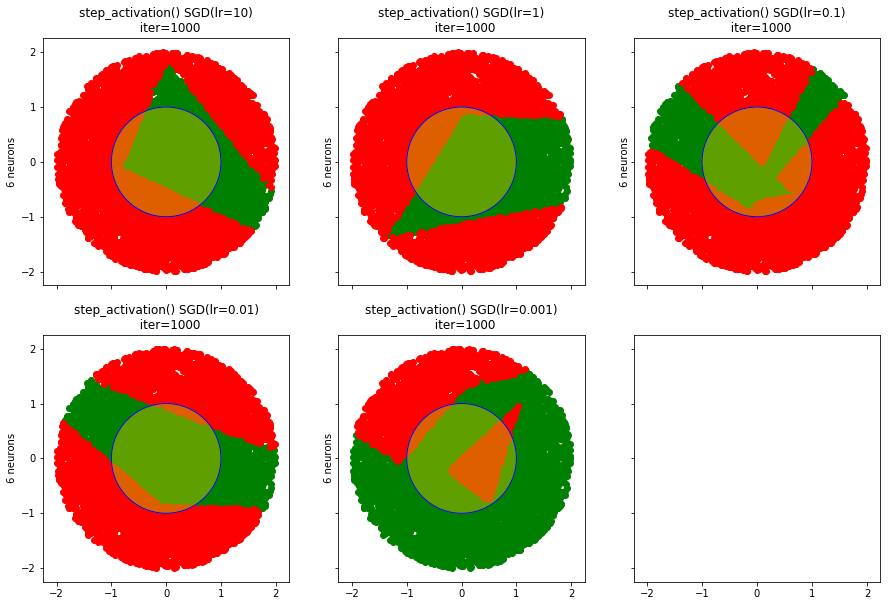

In [22]:
activations = [(step_activation, ())]
optimizers = [torch.optim.SGD]
opti_params = [{'lr': 10}, {'lr': 1},{'lr': 0.1}, {'lr': 0.01}, {'lr': 0.001}]
n_hidden_neurons = [6]
n_epochs=1000

models=compute_models(activations, n_hidden_neurons, dataset, 
                      optimizers=optimizers, opti_params=opti_params,
                      n_epochs=n_epochs, gpu=gpu)

print_models(models, testx)

### More epochs

Computing step_activation() SGD(lr=1)
  iter=50000 for 1 neurons ...At iteration 50000
train loss 0.67 train acc 0.59 val loss 0.67 val acc 0.60
 in 27.05 sec
Computing step_activation() SGD(lr=1)
  iter=50000 for 2 neurons ...At iteration 50000
train loss 0.52 train acc 0.76 val loss 0.51 val acc 0.76
 in 21.32 sec
Computing step_activation() SGD(lr=1)
  iter=50000 for 4 neurons ...At iteration 50000
train loss 0.59 train acc 0.64 val loss 0.59 val acc 0.65
 in 28.18 sec
Computing step_activation() SGD(lr=1)
  iter=50000 for 6 neurons ...At iteration 50000
train loss 0.41 train acc 0.78 val loss 0.43 val acc 0.77
 in 23.42 sec


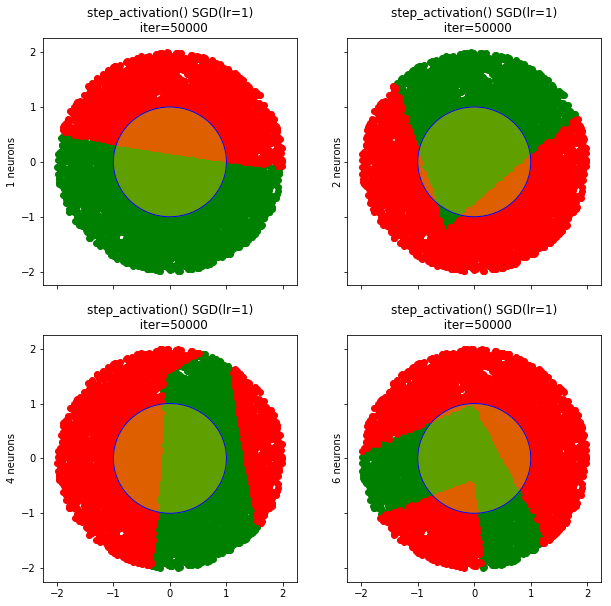

In [23]:
activations = [(step_activation, ())]
n_hidden_neurons = [1, 2, 4, 6]
n_epochs = 50000
opti_params = [{'lr': 1}]

models=compute_models(activations, n_hidden_neurons, dataset, 
                      optimizers=optimizers, opti_params=opti_params,
                      n_epochs=n_epochs)
print_models(models, testx)

### Different weight initialization

Computing step_activation() SGD(lr=0.01)
  iter=10000 for 6 neurons ...At iteration 10000
train loss 0.58 train acc 0.69 val loss 0.58 val acc 0.68
 in 4.30 sec
Computing step_activation() SGD(lr=0.01)
 constant_(0.5,) iter=10000 for 6 neurons ...At iteration 10000
train loss 0.48 train acc 0.78 val loss 0.47 val acc 0.79
 in 4.32 sec
Computing step_activation() SGD(lr=0.01)
 uniform_() iter=10000 for 6 neurons ...At iteration 10000
train loss 0.62 train acc 0.64 val loss 0.63 val acc 0.63
 in 4.48 sec
Computing step_activation() SGD(lr=0.01)
 normal_(0.5, 1) iter=10000 for 6 neurons ...At iteration 10000
train loss 0.40 train acc 0.82 val loss 0.38 val acc 0.84
 in 5.43 sec
Computing step_activation() SGD(lr=0.01)
 xavier_uniform_() iter=10000 for 6 neurons ...At iteration 10000
train loss 0.38 train acc 0.85 val loss 0.39 val acc 0.83
 in 7.99 sec
Computing step_activation() SGD(lr=0.01)
 xavier_normal_() iter=10000 for 6 neurons ...At iteration 10000
train loss 0.37 train acc 0

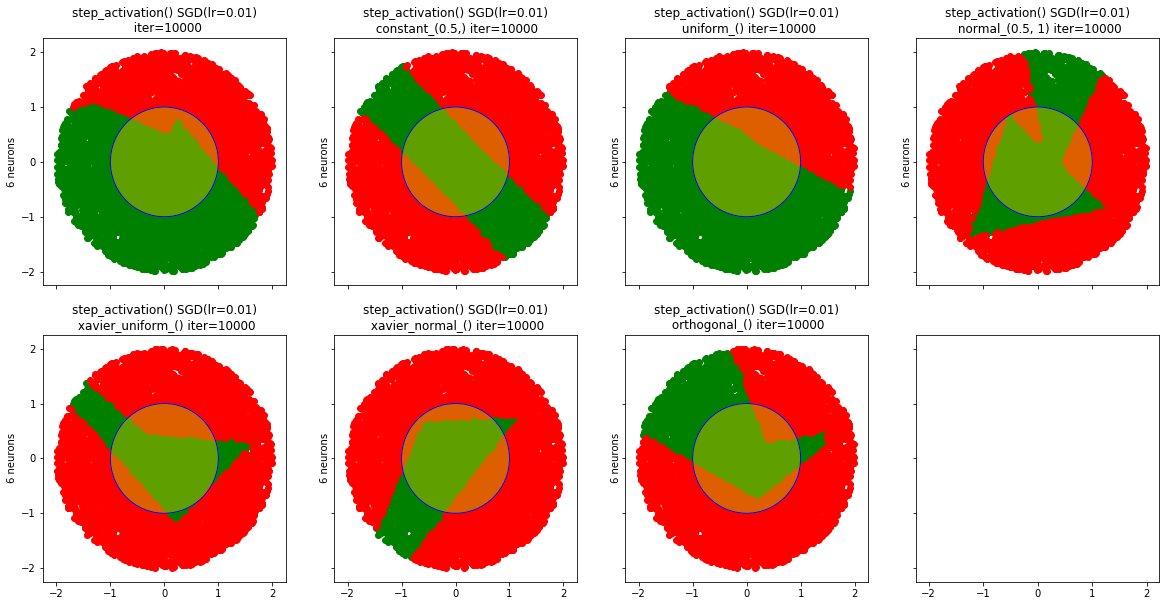

In [24]:
activations = [(step_activation, ())]
initializations = [
    (None, ()),
    (nn.init.constant_, (0.5,)),
    (nn.init.uniform_, ()), 
    (nn.init.normal_, (0.5, 1)),
    (nn.init.xavier_uniform_, ()),
    (nn.init.xavier_normal_, ()),
    (nn.init.orthogonal_, ()),
]

n_hidden_neurons = [6]
n_epochs = 10000
optimizers = [torch.optim.SGD]
opti_params = [{'lr': 0.01}]

models=compute_models(activations, n_hidden_neurons, dataset, 
                      optimizers=optimizers, opti_params=opti_params,
                      initializations=initializations, 
                      n_epochs=n_epochs)
print_models(models, testx)

### More tests? Loss plots?